In [1]:
import qulacs
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator #エラーが出る場合は openfermion を version 1.0.0 以上にしてみてください
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
from pyscf import fci
import numpy as np
import matplotlib.pyplot as plt

In [2]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.977
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

In [3]:
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

In [4]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge

depth = n_qubit

In [5]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))

    return circuit

In [6]:
def cost(theta_list):
    state = QuantumState(n_qubit) #|00000> を準備
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #量子回路を構成
    circuit.update_quantum_state(state) #量子回路を状態に作用
    return qulacs_hamiltonian.get_expectation_value(state) #ハミルトニアンの期待値を計算

In [7]:
cost_history = []
init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

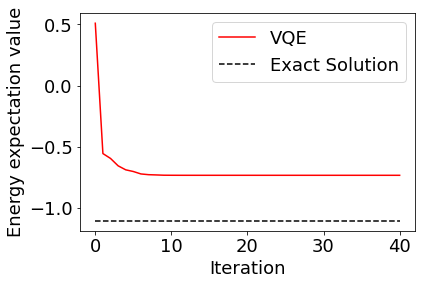

In [8]:
plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [molecule.fci_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

In [10]:
import numpy as np
nqubits = 2
#パウリ演算子を準備する。
pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
pHad = (pX+pZ)/np.sqrt(2)
pP0 = (pI+pZ)/2
pP1 = (pI-pZ)/2

In [28]:
#パウリ演算子を1量子ゲートに変換する。
X=[1]*(nqubits)
Y=[1]*(nqubits)
Z=[1]*(nqubits)
H=[1]*(nqubits)
P0=[1]*(nqubits)
P1=[1]*(nqubits)

for i in range(nqubits):
    for j in range(nqubits):
        if(i != j):
            X[i] = np.kron(pI,X[i])
            Y[i] = np.kron(pI,Y[i])
            Z[i] = np.kron(pI,Z[i])
            H[i] = np.kron(pI,H[i])
            P0[i] = np.kron(pI,P0[i])
            P1[i] = np.kron(pI,P1[i])
        else:
            X[i] = np.kron(pX,X[i])
            Y[i] = np.kron(pY,Y[i])
            Z[i] = np.kron(pZ,Z[i])
            H[i] = np.kron(pHad,H[i])
            P0[i] = np.kron(pP0,P0[i])
            P1[i] = np.kron(pP1,P1[i])
Ide = np.eye(2**nqubits)

0 1
0 [[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
1 1
1 [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


In [12]:
#2量子ゲートを準備する。
CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
CX = [[0 for i in range(nqubits)] for j in range(nqubits)]

for i in range(nqubits):
    for j in range(nqubits):
        CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
        CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))

In [13]:
#変分量子ゲート(X,Y,Zに関する回転の角度を指定できるゲート)を準備する。
from scipy.linalg import expm
def RX(target,angle):
    return expm(-0.5*angle*1.j*X[target])
def RY(target,angle):
    return expm(-0.5*angle*1.j*Y[target])
def RZ(target,angle):
    return expm(-0.5*angle*1.j*Z[target])

In [14]:
#初期状態|0000・・・0>を準備する。
def StateZeros(nqubits):
    State = np.zeros(2**nqubits)
    State[0]=1
    return State

In [15]:
M = (-3.8505 * Ide  - 0.2288 * X[1] - 1.0466 * Z[1] - 0.2288 * X[0] +  0.2613 * np.dot(X[0],X[1]) + \
     0.2288 *np.dot(X[0],Z[1]) - 1.0466*Z[0] + 0.2288* np.dot(Z[0],X[1]) +  0.2356 * np.dot(Z[0],Z[1]) )/2

In [16]:
n_param = 6
def TwoQubitPQC(phi):
    state = StateZeros(2)
    state = np.dot(RX(0,phi[0]),state)
    state = np.dot(RZ(0,phi[1]),state)
    state = np.dot(RX(1,phi[2]),state)
    state = np.dot(RZ(1,phi[3]),state)
    state = np.dot(CX[1][0],state)
    state = np.dot(RZ(1,phi[4]),state)
    state = np.dot(RX(1,phi[5]),state)
    return state

In [17]:
def ExpectVal(Operator,State):
    BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
    tmp = np.dot(BraState,np.dot(Operator,State)) #行列を列ベクトルと行ベクトルではさむ
    return np.real(tmp) #要素の実部を取り出す

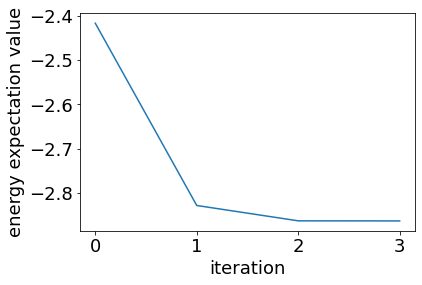

In [18]:
import scipy.optimize
import matplotlib.pyplot as plt

def cost(phi):
    return ExpectVal(M, TwoQubitPQC(phi))

cost_val = [] #コスト関数の変化を保存するための関数

#この関数がiteration ごとに呼ばれる。
def callback(phi):
    global cost_val
    cost_val.append(cost(phi))

init = np.random.rand(n_param)
callback(init)
res = scipy.optimize.minimize(cost, init,
                              method='Powell',
                              callback=callback)
plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()

In [20]:
import scipy.linalg
l, P = scipy.linalg.eigh(M)
print(l[0]) #最小固有値
print(cost(res.x)) #VQEの結果

-2.8626207640766816
-2.8623944534976973


In [21]:
def cost(phi):
    return ExpectVal(M,TwoQubitPQC(phi))+np.random.normal(0,0.01)

def callback(phi):
    global cost_val
    cost_val.append(cost(phi))

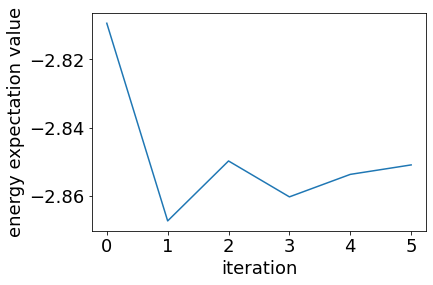

-2.831074499117491


In [22]:
cost_val=[] # コスト関数の履歴
init = np.random.rand(6)
callback(init)
res = scipy.optimize.minimize(cost, init,
                              method='Powell',
                              callback=callback)
plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()
print(cost(res.x))